## TF Version2를 잘하려면, eager 가 기본이라고 한다.

기본 튜토리얼 [URL](https://github.com/tensorflow/docs/blob/master/site/en/guide/eager.ipynb)

* tf.eager
* tf.keras
* tf.GradientTape()
* Variables and optimizers
* Use objects for state during eager execution
* Custom gradients

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from keras.layers import LeakyReLU

import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

tf.enable_eager_execution()

Using TensorFlow backend.


No GPU found


In [3]:
tf.executing_eagerly()

True

In [4]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


In [5]:
a = tf.constant([[1,2],[3,4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [6]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [7]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [8]:

# Obtain numpy value from a tensor:
print(a.numpy())
# => [[1 2]
#     [3 4]]

[[1 2]
 [3 4]]


In [9]:
tfe = tf.contrib.eager

In [10]:
def fizzbuzz(max_num):
    counter = tf.constant(0)
    max_num = tf.convert_to_tensor(max_num)
    for num in range(1, max_num.numpy()+1):
        num = tf.constant(num)
        if int(num % 3) == 0 and int(num % 5) == 0:
            print('FizzBuzz')
        elif int(num % 3) == 0:
            print('Fizz')
        elif int(num % 5) == 0:
            print('Buzz')
        else:
            print(num.numpy())
            print(num)
        counter += 1

In [11]:
fizzbuzz(15)

1
tf.Tensor(1, shape=(), dtype=int32)
2
tf.Tensor(2, shape=(), dtype=int32)
Fizz
4
tf.Tensor(4, shape=(), dtype=int32)
Buzz
Fizz
7
tf.Tensor(7, shape=(), dtype=int32)
8
tf.Tensor(8, shape=(), dtype=int32)
Fizz
Buzz
11
tf.Tensor(11, shape=(), dtype=int32)
Fizz
13
tf.Tensor(13, shape=(), dtype=int32)
14
tf.Tensor(14, shape=(), dtype=int32)
FizzBuzz


## Build A Model

* tf.keras.layers.Layer 를 활용하면 편하게 사용 할 수 있다고 한다.


In [12]:
class MySimpleLayer(tf.keras.layers.Layer) :
    def __init__(self, output_units) :
        super(MySimpleLayer , self).__init__()
        self.output_units = output_units
        
    def build(self, input_shape) :
        self.kernel = self.add_variable("kernel" , [input_shape[-1] , self.output_units])
    
    def call(self, input) :
        return tf.matmul(input , self.kernel )

Use `tf.keras.layers.Dense layer` instead of `MySimpleLayer` above as it has a superset of its functionality (it can also add a bias).

When composing layers into models you can use tf.keras.Sequential to represent models which are a linear stack of layers. It is easy to use for basic models:

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10 , input_shape =(784,)),
    tf.keras.layers.Dense(10) ,
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(1)
])
model

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 8,021
Trainable params: 8,021
Non-trainable params: 0
_________________________________________________________________


tf,keras.Model 로 부터 상속되서 모델을 만들 수 있다고 한다.
* 음 잘 모르겠다 긁적

In [15]:
class MNISTModel(tf.keras.Model) :
    def __init__(self) :
        super(MNISTModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units = 19)
        self.dense2 = tf.keras.layers.Dense(units = 10)
        
    def call(self, input) :
        result = self.dense1(input)
        result = self.dense2(result)
        result = self.dense2(result)
        return result

model = MNISTModel()


# Eager Training

## Computing gradients

*  `자동 미분`은 백프로퍼게이션을 할 때 유용하다. `eager`를 사용할 때는 `tf.GradientTape` 를 사용해 후에 Gradient를 계산할 때 `Trace` 할 수 있다고 한다. 

In [16]:
w = tf.Variable([[5.0]])
with tf.GradientTape() as tape :
    loss = 5*w*w

grad = tape.gradient(loss, w)
print(grad)

tf.Tensor([[50.]], shape=(1, 1), dtype=float32)


# 모델을 훈련시키기

* MNIST 로 해보자
* `tf.data`를 사용하면서 더 큰 모델에 잘 하는 것도 익혀두자

In [17]:

# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))

dataset = dataset.shuffle(1000).batch(32)


In [18]:
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,[3,3],kernel_initializer='he_normal'),
    tf.keras.layers.Activation(LeakyReLU()) ,
    tf.keras.layers.Conv2D(16,[3,3], activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10)
])

In [19]:
for images,labels in dataset.take(1):
    print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.3427664   0.15773454 -0.26301625  0.42443573 -0.2069581  -0.12852414
   0.20416534  0.3360661  -0.19809619 -0.01428229]]


In [20]:
optimizer = tf.train.AdamOptimizer()

loss_history = []


In [21]:

for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 10 == 0:
        print('.', end='')
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

    loss_history.append(loss_value.numpy())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients( zip(grads, mnist_model.trainable_variables),
                               global_step=tf.train.get_or_create_global_step() )

........................................

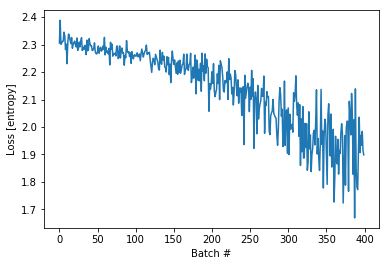

In [23]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()

## Variables and optimizers
* `tf.Variable objects` store `mutable tf.Tensor` values accessed during training to make `automatic differentiation easier.`

* Better encapsulate model parameters by using `tf.Variable with tf.GradientTape`.

In [24]:
class Model(tf.keras.Model) :
    def __init__(self) :
        super(Model , self).__init__()
        self.W = tf.Variable(5. , name = "weight")
        self.B = tf.Variable(5. , name = "bias")
    
    def call(self, inputs) :
        return inputs* self.W + self.B

NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 +2 + noise

def loss(model , inputs , targets) :
    """MSE"""
    error = model(inputs ) - targets 
    return tf.reduce_mean(tf.square(error))

def grad( model , inputs , targets ) :
    with tf.GradientTape() as tape :
        loss_value = loss(model , inputs , targets)
    return tape.gradient(loss_value ,[model.W , model.B])

model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))



Initial loss: 13.692


In [25]:
for i in range(300) :
    grads = grad(model , training_inputs , training_outputs)
    optimizer.apply_gradients(zip(grads , [model.W , model.B]) ,
                             global_step = tf.train.get_or_create_global_step())
    
    if i%20 ==0 :
        print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Loss at step 000: 9.130
Loss at step 020: 0.997
Loss at step 040: 0.996
Loss at step 060: 0.996
Loss at step 080: 0.996
Loss at step 100: 0.996
Loss at step 120: 0.996
Loss at step 140: 0.996
Loss at step 160: 0.996
Loss at step 180: 0.996
Loss at step 200: 0.996
Loss at step 220: 0.996
Loss at step 240: 0.996
Loss at step 260: 0.996
Loss at step 280: 0.996
Final loss: 0.996
W = 3.0158870220184326, B = 2.0361011028289795


## Use objects for state during eager execution

* With graph execution, program state (such as the variables) is stored in global collections and their lifetime is managed by the `tf.Session` object. 
* In contrast, `during eager execution` the lifetime of state objects is determined by the lifetime of their corresponding Python object.

## Variables are objects
* During eager execution, variables persist until the last reference to the object is removed, and is then deleted.

In [27]:
if tf.test.is_gpu_available():
    with tf.device("gpu:0"):
        v = tf.Variable(tf.random_normal([1000, 1000]))
        v = None  # v no longer takes up GPU memory

## Object-based saving
* `tf.train.Checkpoint` can `save` and `restore` `tf.Variables` to and from checkpoints:

In [30]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [32]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [33]:
# Change the variable after saving.
x.assign(11.)  

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=11.0>

* checkpint를 활용하여 `save` 한다음에 다시 `restore` 하니깐, 이전에 할당한 `x`는 사라지고 저장된 것이 불러와진다.

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x.numpy())  # => 2.0

2.0


* `To save and load models,` tf.train.Checkpoint stores the internal state of objects, without requiring hidden variables.
* To record the state of a model, an optimizer, and a global step, pass them to a tf.train.Checkpoint:

In [38]:
import os
import tempfile

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
checkpoint_dir = tempfile.mkdtemp()
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [39]:
checkpoint_prefix

'/tmp/tmp5jj0dto2/ckpt'

In [40]:
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model,
                           optimizer_step=tf.train.get_or_create_global_step())

In [41]:
root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Object-oriented metrics

* `tfe.metrics` are `stored as objects.` 
* Update a metric by passing the new data to the callable, and retrieve the result using the tfe.metrics.result method, 

> for example :

In [45]:

m = tfe.metrics.Mean("loss")
m(0)
m(5)
m.result()  # => 2.5
m([8, 9])
m.result()  # => 5.5
m.result().numpy()

5.5

## Summaries and TensorBoard

`TensorBoard` is a visualization tool for understanding, debugging and optimizing the model training process. 
* It uses summary events that are written while executing the program.

`tf.contrib.summary` is compatible with both eager and graph execution environments. 
Summary operations, such as `tf.contrib.summary.scalar`, are inserted during model construction. 

For example, to record summaries once every 100 global steps:

In [47]:
global_step = tf.train.get_or_create_global_step()
logdir = "./tb/"
writer = tf.contrib.summary.create_file_writer(logdir)
writer.set_as_default()

for _ in range(10):
    global_step.assign_add(1)
  # Must include a record_summaries method
    with tf.contrib.summary.record_summaries_every_n_global_steps(100):
        # your model code goes here
        tf.contrib.summary.scalar('global_step', global_step)

In [48]:
!ls tb/

events.out.tfevents.1549792897.esc8000g42.v2


## Advanced automatic differentiation topics

* Dynamic models

* `tf.GradientTape` can also be used in dynamic models. 

* This example for a backtracking `line search algorithm` looks like normal NumPy code, except there are gradients and is differentiable, despite the complex control flow:


In [49]:
def line_search_step(fn, init_x, rate=1.0):
    with tf.GradientTape() as tape:
    # Variables are automatically recorded, but manually watch a tensor
        tape.watch(init_x)
        value = fn(init_x)
    grad = tape.gradient(value, init_x)
    grad_norm = tf.reduce_sum(grad * grad)
    init_value = value
    while value > init_value - rate * grad_norm:
        x = init_x - rate * grad
        value = fn(x)
        rate /= 2.0
    return x, value

## Additional functions to compute gradients

* `tf.GradientTape` is a powerful interface for computing gradients, `but` there is another Autograd-style API available for automatic differentiation. 
* These functions are useful if writing math code with only tensors and gradient functions, and `without tf.variables`:
    * `tfe.gradients_function` —Returns a function that computes the derivatives of its input function parameter with respect to its arguments. 
    The input function parameter must return a scalar value. 
    
    When the returned function is invoked, it returns a list of tf.Tensor objects: one element for each argument of the input function. 
    
    Since anything of interest must be passed as a function parameter, this becomes unwieldy if there's a dependency on many trainable parameters.
    
    * `tfe.value_and_gradients_function` —Similar to tfe.gradients_function, but when the returned function is invoked, it returns the value from the input function in addition to the list of derivatives of the input function with respect to its arguments.

In [64]:
def square(x):
    return tf.multiply(tf.square(x), x)

grad = tfe.gradients_function(square)

In [65]:
square(3.).numpy()

27.0

In [66]:
grad(3.)[0].numpy()

27.0

In [67]:
"""
The second-order derivative of square:
"""

gradgrad = tfe.gradients_function(lambda x: grad(x)[0])
gradgrad(3.)[0].numpy()



18.0

In [69]:
"""
The third-order derivative is None:
"""

gradgradgrad = tfe.gradients_function(lambda x: gradgrad(x)[0])
gradgradgrad(3.)[0].numpy()

6.0

In [70]:
def abs(x):
    return x if x > 0. else -x

grad = tfe.gradients_function(abs)

In [71]:
grad(3.)[0].numpy()

1.0

In [72]:
grad(-3.)[0].numpy()

-1.0

## Custom Gradients

* `Custom gradients` are an easy way to override gradients in eager and graph execution. 
* Within the forward function, define the gradient with respect to the inputs, outputs, or intermediate results. 

> For example, here's an easy way to clip the norm of the gradients in the backward pass:


In [73]:
@tf.custom_gradient
def clip_gradient_by_norm(x, norm):
    y = tf.identity(x)
    def grad_fn(dresult):
        return [tf.clip_by_norm(dresult, norm), None]
    return y, grad_fn

In [74]:
def log1pexp(x):
    return tf.log(1 + tf.exp(x))
grad_log1pexp = tfe.gradients_function(log1pexp)

In [76]:
# The gradient computation works fine at x = 0.
grad_log1pexp(5.)[0].numpy()

0.9933072

In [78]:
"""
However, x = 100 fails because of numerical instability.
"""

grad_log1pexp(100.)[0].numpy()

nan

* the `log1pexp` function can be analytically simplified with `a custom gradient.` 

* The implementation below `reuses the value for tf.exp(x)` that is computed during the forward pass—making it more efficient by eliminating redundant calculations:

In [79]:

@tf.custom_gradient
def log1pexp(x):
    e = tf.exp(x)
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.log(1 + e), grad

grad_log1pexp = tfe.gradients_function(log1pexp)

In [84]:
# As before, the gradient computation works fine at x = 0.
grad_log1pexp(0.)[0].numpy()

0.5

In [82]:
"""
And the gradient computation also works at x = 100.
"""


grad_log1pexp(100.)[0].numpy()

1.0

## Performance


Computation is automatically offloaded to GPUs during eager execution. If you want control over where a computation runs you can enclose it in a tf.device('/gpu:0') block (or the CPU equivalent):

In [85]:
import time

def measure(x, steps):
    # TensorFlow initializes a GPU the first time it's used, exclude from timing.
    tf.matmul(x, x)
    start = time.time()
    for i in range(steps):
        x = tf.matmul(x, x)
  # tf.matmul can return before completing the matrix multiplication
  # (e.g., can return after enqueing the operation on a CUDA stream).
  # The x.numpy() call below will ensure that all enqueued operations
  # have completed (and will also copy the result to host memory,
  # so we're including a little more than just the matmul operation
  # time).
    _ = x.numpy()
    end = time.time()
    return end - start

shape = (1000, 1000)
steps = 200
print("Time to multiply a {} matrix by itself {} times:".format(shape, steps))

# Run on CPU:
with tf.device("/cpu:0"):
    print("CPU: {} secs".format(measure(tf.random_normal(shape), steps)))

# Run on GPU, if available:
if tfe.num_gpus() > 0:
    with tf.device("/gpu:0"):
        print("GPU: {} secs".format(measure(tf.random_normal(shape), steps)))
else:
    print("GPU: not found")

Time to multiply a (1000, 1000) matrix by itself 200 times:
CPU: 0.9748802185058594 secs
GPU: not found


In [86]:
if tf.test.is_gpu_available():
    x = tf.random_normal([10, 10])

    x_gpu0 = x.gpu()
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)    # Runs on CPU
    _ = tf.matmul(x_gpu0, x_gpu0)  # Runs on GPU:0

    if tfe.num_gpus() > 1:
        x_gpu1 = x.gpu(1)
        _ = tf.matmul(x_gpu1, x_gpu1)  # Runs on GPU:1

## Work with graphs

* While eager execution makes development and debugging more interactive, tensorFlow graph execution has advantages for distributed training, performance optimizations, and production deployment.

* `However`, `writing graph code` can feel different than writing regular Python code and more `difficult to debug`.

For building and training graph-constructed models, the Python program first builds a graph representing the computation, then invokes Session.run to send the graph for execution on the C++-based runtime. This provides:

* Automatic differentiation using static autodiff.
* Simple deployment to a platform independent server.
* Graph-based optimizations (common subexpression elimination, constant-folding, etc.).
* Compilation and kernel fusion.
* Automatic distribution and replication (placing nodes on the distributed system).


`Deploying code written for eager execution is more difficult` 
* either generate a graph from the model, or run the Python runtime and code directly on the server.

## Write compatible code

`The same code written for eager execution` will also build a graph during graph execution. 
* Do this by simply running the same code in a new Python session where eager execution is not enabled.

Most TensorFlow operations work during eager execution, but there are some things to `keep in mind`:

* `Use tf.data for input processing instead of queues`. **It's faster and easier.**
* `Use object-oriented layer APIs—like tf.keras.layers and tf.keras.Model` **since they have explicit storage for variables.**
* Most model code works **the same** `during eager and graph execution`, but there are exceptions. (For example, dynamic models using Python control flow to change the computation based on inputs.)
* `Once eager execution` is enabled with tf.enable_eager_execution, it `cannot be turned off`. `Start a new Python session to return to graph execution.`

## [example](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples)
### 다음에는 위에 있는 example을 보면서 연습을 해봐야겠다.

## Use eager execution in a graph environment

* `Selectively` `enable` **eager execution in a TensorFlow graph** environment using `tfe.py_func.` * This is used when tf.enable_eager_execution() has not been called.

In [87]:
def my_py_func(x):
    x = tf.matmul(x, x)  # You can use tf ops
    print(x)  # but it's eager!
    return x

with tf.Session() as sess:
    x = tf.placeholder(dtype=tf.float32)
  # Call eager function in graph!
    pf = tfe.py_func(my_py_func, [x], tf.float32)
  
    sess.run(pf, feed_dict={x: [[2.0]]})  # [[4.0]]
    

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


## 공부할 것은 많구만.................